- Backbone  : ViT-Small/16 (≈22 M params, ImageNet pretrained)  
- Clients   : 5 clinets (Dirichlet-α = 0.1 skewed)  
- Dataset : EuroSAT (27k images)
- Epochs    : 3 per client  |  Batch size: 64  |  Checkpoints every epoch  

### 0.$\,$Google-Drive mount (skip on local Jupyter)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT_PATH = "/content/drive/MyDrive/Graduation Thesis/fl_localize_stitch_vit/"
# ROOT_PATH = "/content/drive/Othercomputers/Victus/Disk D/New Uzb Semester 8/Graduation Thesis/fl_localize_stitch_vit/"
# ROOT_PATH = "./"              # to run locally

Mounted at /content/drive


#### 0a. Dependencies

In [ ]:
import subprocess, sys, importlib, pathlib, os

PKGS = ["torch", "torchvision", "timm", "tqdm"]
for pkg in PKGS:
    try:
        importlib.import_module(pkg)
    except ModuleNotFoundError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [ ]:
ROOT_PATH = pathlib.Path(ROOT_PATH).resolve()
sys.path.extend([str(ROOT_PATH)])

ckpt_dir = ROOT_PATH / "checkpoints"
ckpt_dir.mkdir(exist_ok=True)

### 1.$\,$Hyper-parameters & torchvision transforms  

In [ ]:
NUM_CLIENTS = 5
EPOCHS      = 4
BATCH_SIZE  = 64
IMG_SIZE    = 224    # ViT default patch‑16 grid
ALPHA       = 0.1    # Dirichlet concentration → stronger skew < 1, weaker skew > 1
SUBSET_FRAC = 1.0
DATASET     = "EuroSAT"
SEED        = 42

from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),        # 1-→3 channels
    transforms.Normalize((0.1307,)*3, (0.3081,)*3),
])

### 2.$\,$Data loading (with sub-sampling) & skewed client splits

In [ ]:
from torchvision.datasets import DTD, StanfordCars, EuroSAT
from torch.utils.data import DataLoader, Subset
import torch, numpy as np, math

torch.manual_seed(SEED)

def downsample(ds, frac, seed=SEED):
    torch.manual_seed(seed)

    if frac >= 1.0:
        return ds
    n = math.ceil(len(ds) * frac)
    keep = torch.randperm(len(ds))[:n]
    return Subset(ds, keep)

DATA_ROOT = "./data"
def make_dataset(name, subset_frac=SUBSET_FRAC, seed=SEED):
    if name == "EuroSAT":
        # Load the full dataset once
        full_dataset = EuroSAT(DATA_ROOT, transform=preprocess, download=True)
        # Split into 80% train / 20% test
        train_size = int(0.8 * len(full_dataset))
        test_size  = len(full_dataset) - train_size
        train, test = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    elif name == "DTD":
        train = DTD(DATA_ROOT, split="train",        download=True, transform=preprocess)
        test  = DTD(DATA_ROOT, split="test",         download=True, transform=preprocess)
    # elif name == "RESISC45":
    #     train = RESISC45(DATA_ROOT, split="train",   download=True, transform=preprocess)
    #     test  = RESISC45(DATA_ROOT, split="test",    download=False, transform=preprocess)
    elif name == "StanfordCars":
        train = StanfordCars(DATA_ROOT, split="train",       download=True, transform=preprocess)
        test  = StanfordCars(DATA_ROOT, split="test",        download=True, transform=preprocess)
    else:
        raise ValueError("Unknown dataset")
    return downsample(train, subset_frac, seed=seed), test


# Dirichlet split
def create_skewed_clients(dataset, num_clients=NUM_CLIENTS, alpha=ALPHA, seed=SEED):
    rng = np.random.default_rng(seed)

    if hasattr(dataset, "targets"):
        labels = np.array(dataset.targets)
    else:
        labels = np.array([y for _, y in dataset])

    classes = np.unique(labels)
    class_indices = [np.where(labels == c)[0] for c in classes]
    clients = [[] for _ in range(num_clients)]
    for class_i in class_indices:
        rng.shuffle(class_i)
        parts = rng.dirichlet(alpha * np.ones(num_clients))
        splits = (np.cumsum(parts) * len(class_i)).astype(int)[:-1]
        for cli, chunk in zip(clients, np.split(class_i, splits)):
            cli.extend(chunk)
    return clients, len(classes)


train_ds, test_ds = make_dataset(DATASET)

client_indices, NUM_CLASSES = create_skewed_clients(train_ds)
make_loader = lambda subset: DataLoader(subset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2, pin_memory=True)
train_loaders = [make_loader(Subset(train_ds, idx)) for idx in client_indices]

test_loader   = DataLoader(test_ds, batch_size=256, shuffle=False,
                            num_workers=2, pin_memory=True)

print(f"{DATASET}: {len(train_ds):5d} train   {len(test_ds):5d} test   {NUM_CLASSES} classes")

100%|██████████| 94.3M/94.3M [00:00<00:00, 324MB/s]


EuroSAT: 21600 train    5400 test   10 classes


### 3.$\,$ViT-Small/16 model

In [ ]:
import timm, torch.nn as nn

BACKBONE_NAME = "vit_small_patch16_224"  # ~22 M parameters

def make_classifier(num_classes: int = NUM_CLASSES):
    model = timm.create_model(BACKBONE_NAME, pretrained=True)
    return model

### 4.$\,$Train Clients

In [ ]:
from torch.optim import AdamW
from torch.nn.functional import cross_entropy
from tqdm import tqdm

def train_model(model, loader, client_id, epochs=EPOCHS, device="cuda"):
    model.to(device)

    opt = AdamW(model.parameters(), lr=3e-4)
    scaler = torch.amp.GradScaler('cuda')

    for ep in range(1, epochs+1):
        model.train()

        pbar = tqdm(loader, desc=f"Client{client_id} Epoch{ep}")
        for x, y in pbar:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            opt.zero_grad()

            with torch.amp.autocast('cuda'):
                out = model(x)
                loss = cross_entropy(out, y)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()

        # Checkpoint
        torch.save(model.state_dict(), ckpt_dir / f"client{client_id}_ep{ep}.pt")

    return model.cpu().eval()          # leave in eval mode!

In [ ]:
# Train all clients
client_models = []
for cid, ld in enumerate(train_loaders):
    client_models.append(train_model(make_classifier(), ld, cid))

#### Or load weights (state dict) from a checkpoint:

In [ ]:
client_models = []
ckpt_dir = pathlib.Path(ROOT_PATH) / "checkpoints"

for cid in range(NUM_CLIENTS):
    model = timm.create_model(BACKBONE_NAME)

    client_ckpt = f"client{cid}_ep{EPOCHS}.pt"
    state = torch.load(ckpt_dir / client_ckpt, map_location="cpu")

    model.load_state_dict(state, strict=True)
    client_models.append(model.eval())

#### 4a. Evaluate clients separately

Let's see what are the **client accuracies** trained on **imbalanced data**:

In [ ]:
def accuracy(model):
    model.eval().cuda()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            preds.extend(model(x.cuda()).argmax(1).cpu().numpy())
            labels.extend(y.numpy())
    model.cpu()
    return (np.array(preds) == np.array(labels)).mean()

In [ ]:
import copy

print("Client local accuracies:")

for cid, (clmodel, ld) in enumerate(zip(client_models, train_loaders)):
    acc   = accuracy(clmodel)
    print(f"  client{cid}:  {acc:.4f}")

Client local accuracies:
  client0:  0.2909
  client1:  0.4148
  client2:  0.5228
  client3:  0.4444
  client4:  0.6926


In [ ]:
print("Client initial train dataset sizes:")

for i, ld in enumerate(train_loaders):
    print(f"  client{i}:  {len(ld.dataset)}")

Client initial train dataset sizes:
  client0:  1716
  client1:  5266
  client2:  7453
  client3:  2754
  client4:  4411


### 5.$\,$Localizer

In [ ]:
import torch
from typing import Dict, List

class SimpleLocalizer:
    def __init__(self, pretrained: nn.Module, finetuned: nn.Module, K=0.95):
        # δ = θ_finetuned − θ_pretrained
        self.delta = {n: (f.detach() - p.detach())     # task vector
                      for (n, p), (_, f) in zip(pretrained.named_parameters(),
                                                finetuned.named_parameters())}

        # Global threshold for top-k magnitude
        all_vals = torch.cat([d.flatten().abs() for d in self.delta.values()])

        # add normal noise
        all_vals = all_vals + torch.normal(mean=0, std=torch.std(all_vals) * 0.05, size=all_vals.shape)

        k = max(1, int(K * all_vals.numel()))    # max() is for safety: to choose at least one
        thresh = torch.topk(all_vals, k).values[-1]     # topk() returns [(values), (indices)] in decreasing order.

        # sparse task vector τ = m ⊙ δ
        self.task_vec = {n: (d * (d.abs() >= thresh)).clone() for n, d in self.delta.items()}

    def task_vector(self):
        return self.task_vec

In [ ]:
task_vectors = []
pretrained = timm.create_model(BACKBONE_NAME, pretrained=False).eval()

for cid, clmodel in enumerate(client_models):
    print(f"Localizing client {cid}")
    task_vectors.append(SimpleLocalizer(pretrained, clmodel, K=0.95).task_vector())

Localizing client 0
Localizing client 1
Localizing client 2
Localizing client 3
Localizing client 4


### 6.$\,$Stitch task vectors
top-k% largest magnitude weights, Yadav et al. 2023

In [ ]:
import copy
def simpleStitcher(pretrained: nn.Module, task_vectors: List[Dict[str, torch.Tensor]]):
    merged = pretrained.state_dict()

    # given a weight w, merged[n][w] = sum(tv[n][w] for tv in task_vectors) / (the number of clients whose weight w is not zero)
    for n in merged:
        numer = sum(tv[n] for tv in task_vectors)
        denom = torch.zeros_like(numer)
        # denom += NUM_CLIENTS

        # a = task_vectors[0][n] != 0
        # denom += a
        # print(denom);break

        for tv in task_vectors:
            denom += (tv[n] != 0)
        denom.clamp_min_(1)
        merged[n] += numer / denom

    new_model = copy.deepcopy(pretrained)
    new_model.load_state_dict(merged, strict=True)

    return new_model.eval()

In [ ]:
stitched_model = simpleStitcher(pretrained, task_vectors)

#### 6a. To simulate Multi-Round Communication merging with the LaS algorithm, FedAvg, Gaussian DP-FedAvg

[RUN THE `8. Evaluation` cells FIRST]


In [ ]:
N = 11
fedavg_accuracy = [fedavg_acc]
stitched_accuracy = [stitched_acc]
fedavgnoise_accuracy = [fedavgnoise_acc]

# Load new train data and test data
full_dataset = EuroSAT(DATA_ROOT, transform=preprocess, download=True)
# Split into 80% train / 20% test
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size

torch.manual_seed(SEED)
train, test = torch.utils.data.random_split(full_dataset, [train_size, test_size])

for i in range(N):
    # Load new train data
    train_ds, test_ds = downsample(train, SUBSET_FRAC, seed=i+SEED), downsample(test, frac=0.50, seed=i+SEED)

    client_indices, num_cls = create_skewed_clients(train_ds)
    make_loader = lambda subset: DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    train_loaders = [make_loader(Subset(train_ds, idx)) for idx in client_indices]
    test_loader   = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Train
    client_models_las = []
    for cid, ld in enumerate(train_loaders):
        client_models_las.append(train_model(copy.deepcopy(stitched_model), ld, cid, epochs=1))

    client_models_fedavg = []
    for cid, ld in enumerate(train_loaders):
        client_models_fedavg.append(train_model(copy.deepcopy(fedavg_model), ld, cid, epochs=1))

    client_models_fedavgnoise = []
    for cid, ld in enumerate(train_loaders):
        client_models_fedavgnoise.append(train_model(copy.deepcopy(fedavgnoise_model), ld, cid, epochs=1))


    # a. FedAvg
    fedavg_model  = weight_average(client_models_fedavg).eval()

    # b. LaS algorithm
    task_vectors = []
    # Localize
    for cid, clmodel in enumerate(client_models_las):
        task_vectors.append(SimpleLocalizer(stitched_model, clmodel, K=1 - 0.035*stitched_acc).task_vector())    # K = 1 - µ*prev_acc
    # Stitch
    stitched_model = simpleStitcher(stitched_model, task_vectors)

    # c. FedAvg Noise
    fedavgnoise_model = weight_average_noise(client_models_fedavgnoise).eval()


    # Evaluate
    fedavg_acc = accuracy(fedavg_model)
    stitched_acc = accuracy(stitched_model)
    fedavgnoise_acc = accuracy(fedavgnoise_model)

    fedavg_accuracy.append(fedavg_acc)
    stitched_accuracy.append(stitched_acc)
    fedavgnoise_accuracy.append(fedavgnoise_acc)

    print(f"Round {i+2}: FedAvg acc={fedavg_acc}, LaS acc={stitched_acc}, FedAvgNoise acc={fedavgnoise_acc}")

Client4 Epoch1: 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Round 2: FedAvg acc=0.7148148148148148, LaS acc=0.667037037037037, FedAvgNoise acc=0.6862962962962963


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.35it/s]


Round 3: FedAvg acc=0.7496296296296296, LaS acc=0.7251851851851852, FedAvgNoise acc=0.747037037037037


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.51it/s]


Round 4: FedAvg acc=0.7703703703703704, LaS acc=0.7318518518518519, FedAvgNoise acc=0.7325925925925926


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.42it/s]


Round 5: FedAvg acc=0.7588888888888888, LaS acc=0.717037037037037, FedAvgNoise acc=0.8055555555555556


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.50it/s]


Round 6: FedAvg acc=0.85, LaS acc=0.8485185185185186, FedAvgNoise acc=0.8281481481481482


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]


Round 7: FedAvg acc=0.7985185185185185, LaS acc=0.86, FedAvgNoise acc=0.8251851851851851


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.33it/s]


Round 8: FedAvg acc=0.9418518518518518, LaS acc=0.9214814814814815, FedAvgNoise acc=0.857037037037037


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.37it/s]


Round 9: FedAvg acc=0.904074074074074, LaS acc=0.9281481481481482, FedAvgNoise acc=0.8281481481481482


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.48it/s]


Round 10: FedAvg acc=0.89, LaS acc=0.9437037037037037, FedAvgNoise acc=0.8655555555555555


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.47it/s]


Round 11: FedAvg acc=0.9018518518518519, LaS acc=0.9255555555555556, FedAvgNoise acc=0.9359259259259259


Client4 Epoch1: 100%|██████████| 69/69 [00:15<00:00,  4.33it/s]


Round 12: FedAvg acc=0.9188888888888889, LaS acc=0.9481481481481482, FedAvgNoise acc=0.9440740740740741


### 7.$\,$ Baselines

#### Single fine-tuned model

A single model trained on the union of all client data.

In [ ]:
full_dataset = EuroSAT(DATA_ROOT, transform=preprocess, download=True)
# Split into 80% train / 20% test
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size
train_single, test_single = torch.utils.data.random_split(full_dataset, [train_size, test_size])

full_loader = DataLoader(train_single, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)

baseline_model = train_model(make_classifier(), full_loader, "Baseline", epochs=4)

ClientBaseline Epoch4: 100%|██████████| 338/338 [01:06<00:00,  5.10it/s]


Or load from a checkpoint:

In [ ]:
ckpt_dir = pathlib.Path(ROOT_PATH) / "checkpoints"

baseline_model = timm.create_model(BACKBONE_NAME)
baseline_ckpt = f"clientBaseline_ep2.pt"

state = torch.load(ckpt_dir / baseline_ckpt, map_location="cpu")
baseline_model.load_state_dict(state, strict=True)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

#### FedAvg (weight average)

In [ ]:
def weight_average(models):
    avg = copy.deepcopy(models[0])
    with torch.no_grad():
        for k in avg.state_dict().keys():
            avg.state_dict()[k].copy_(
                sum(m.state_dict()[k] for m in models) / len(models))
    return avg

fedavg_model  = weight_average(client_models).eval()

In [ ]:
def weight_average_noise(models):
    avg = copy.deepcopy(models[0])
    with torch.no_grad():
        for k in avg.state_dict().keys():
            avg.state_dict()[k].copy_(
                sum(m.state_dict()[k] for m in models) / len(models)
            )
            # add normal noise
            avg.state_dict()[k] += torch.normal(mean=0, std=torch.std(avg.state_dict()[k]) * 0.04, size=avg.state_dict()[k].shape)

    return avg

fedavgnoise_model  = weight_average_noise(client_models).eval()

### 8.$\,$Evaluation

In [ ]:
fedavg_acc = accuracy(fedavg_model)
fedavg_acc

np.float64(0.5757407407407408)

In [ ]:
fedavgnoise_acc = accuracy(fedavgnoise_model)
fedavgnoise_acc

np.float64(0.5968518518518519)

In [ ]:
stitched_acc = accuracy(stitched_model)
stitched_acc

np.float64(0.5785185185185185)

In [ ]:
baseline_acc = accuracy(baseline_model)
baseline_acc

np.float64(0.9714814814814815)

### Plot

initial K=0.95

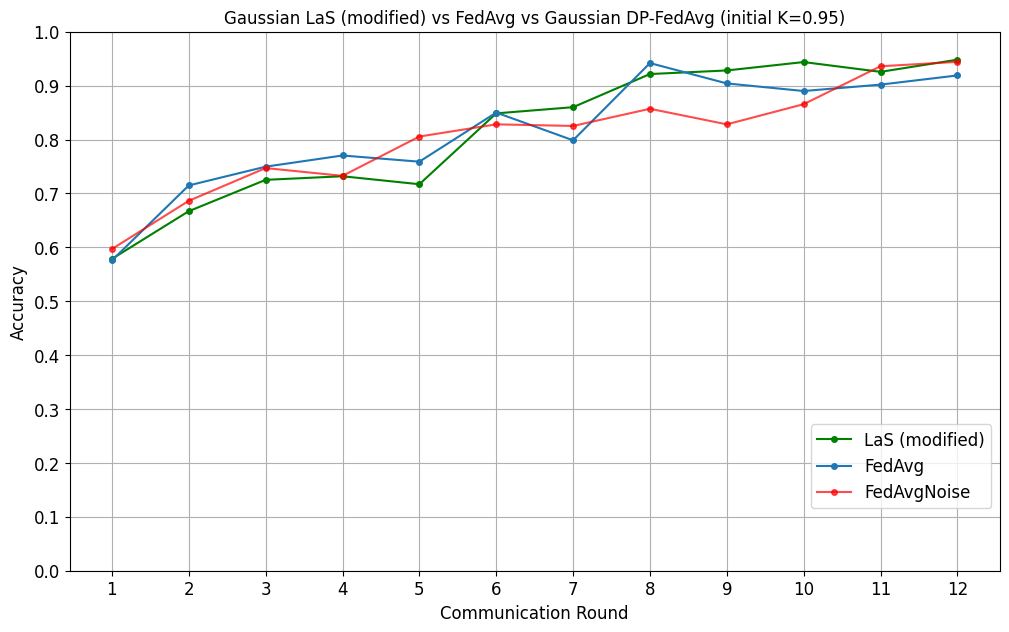

In [5]:
import matplotlib.pyplot as plt

x_values = range(1, N+2)

plt.figure(figsize=(12, 7))
plt.plot(x_values, stitched_accuracy, label='LaS (modified)', color='green', marker='o', markersize=4)
plt.plot(x_values, fedavg_accuracy, label='FedAvg', marker='o', markersize=4)
plt.plot(x_values, fedavgnoise_accuracy, label='FedAvgNoise', color='red', alpha=0.7, marker='o', markersize=4)


plt.xlabel('Communication Round', fontsize='large')
plt.ylabel('Accuracy', fontsize='large')
plt.title('Gaussian LaS (modified) vs FedAvg vs Gaussian DP-FedAvg (initial K=0.95)')

# Set x-axis ticks to integers
plt.xticks(x_values)

# Set y-axis ticks with increments of 0.1
plt.yticks([i / 10 for i in range(11)])
plt.tick_params(axis='both', labelsize='large')  # Increase tick font size

plt.ylim(0, 1)  # Set Y-axis limits from 0 to 1

# Move legend lower
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize='large')
plt.grid(True)

# Save the plot as a vector image
plt.savefig('comparison_eurosat_gnoise.svg', format='svg')

plt.show()